In [5]:
!pip install torch-geometric

  Using cached torch_geometric-2.6.1-py3-none-any.whl.metadata (63 kB)
Using cached torch_geometric-2.6.1-py3-none-any.whl (1.1 MB)


In [6]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv

# Load Cora dataset
dataset = Planetoid(root='data/Cora', name='Cora')
data = dataset[0]  # The graph data

Processing...
Done!


In [9]:
# Define a simple Graph Convolutional Network
class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)  # First GCN layer
        self.conv2 = GCNConv(hidden_dim, output_dim)  # Second GCN layer

    def forward(self, data):
        x, A = data.x, data.edge_index  # Node features and adjacency info
        x = self.conv1(x, A)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, A)
        return F.log_softmax(x, dim=1)  # Log-softmax for classification

# Instantiate the model
model = GCN(input_dim=dataset.num_node_features, hidden_dim=16, output_dim=dataset.num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

In [10]:
# Training loop
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

# Test function
def test():
    model.eval()
    out = model(data)
    pred = out.argmax(dim=1)
    correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
    acc = int(correct) / int(data.test_mask.sum())
    return acc

# Run training
for epoch in range(200):
    loss = train()
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Loss = {loss:.4f}")

# Evaluate the model
accuracy = test()
print(f"Test Accuracy: {accuracy:.4f}")

Epoch 0: Loss = 1.9569
Epoch 10: Loss = 0.6932
Epoch 20: Loss = 0.1966
Epoch 30: Loss = 0.1016
Epoch 40: Loss = 0.0834
Epoch 50: Loss = 0.0418
Epoch 60: Loss = 0.0338
Epoch 70: Loss = 0.0516
Epoch 80: Loss = 0.0295
Epoch 90: Loss = 0.0345
Epoch 100: Loss = 0.0442
Epoch 110: Loss = 0.0238
Epoch 120: Loss = 0.0280
Epoch 130: Loss = 0.0329
Epoch 140: Loss = 0.0439
Epoch 150: Loss = 0.0387
Epoch 160: Loss = 0.0246
Epoch 170: Loss = 0.0477
Epoch 180: Loss = 0.0269
Epoch 190: Loss = 0.0280
Test Accuracy: 0.7990


<Figure size 800x600 with 0 Axes>

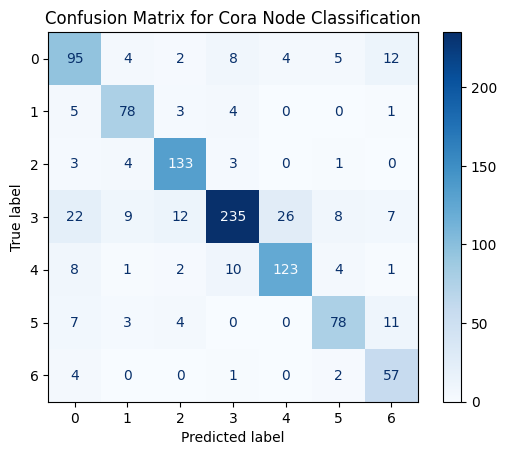

In [12]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate predictions
model.eval()
with torch.no_grad():
    out = model(data)
    preds = out.argmax(dim=1)

# Extract predictions and true labels for the test set
y_true = data.y[data.test_mask].cpu().numpy()
y_pred = preds[data.test_mask].cpu().numpy()

# Compute and plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_true))

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
cmd.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix for Cora Node Classification')
plt.show()
